# Use The Joker to explore long-period companion parameter space.

In [1]:
import os

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import radvel
import corner
import astropy.units as u

import pymc3 as pm
import exoplanet.units as xu
import exoplanet as xo

import schwimmbad
from twobody import KeplerOrbit, Barycenter
import thejoker as tj

%matplotlib inline

## Load the final search posteriors for test stars. Extract the RV data, and subtract the best-fit gamma offsets for the pre- and post-upgrade sets.

In [2]:
data = pd.read_csv('../rvdata/vst213472.csv')
#post = radvel.posterior.load('../213472/post_final.pkl')
#chains = pd.read_csv('../213472/chains.csv.tar.bz2')

In [3]:
time = np.asarray(data.jd)
mnvel = np.asarray(data.mnvel)
errvel = np.asarray(data.errvel)
# Make initial guess at jitter from HIRES errors.
jitter = np.median(errvel)

#Use correct units for RVs. Time is in days for TheJoker.
time   *= u.day
mnvel  *= u.m/u.s
errvel *= u.m/u.s
jitter *= u.m/u.s

In [4]:
data_j = data.query('tel == "j"')
data_k = data.query('tel == "k"')

time_j = np.asarray(data_j.jd)
mnvel_j = np.asarray(data_j.mnvel)# - np.median(data.mnvel))
errvel_j = np.asarray(data_j.errvel)
# Make initial guess at jitter from HIRES errors.
jitter_j = np.median(errvel_j)

#Use correct units for RVs. Time is in days for TheJoker.
time_j   *= u.day
mnvel_j  *= u.m/u.s
errvel_j *= u.m/u.s
jitter_j *= u.m/u.s

In [5]:
time_k = np.asarray(data_k.jd)
mnvel_k = np.asarray(data_k.mnvel)# - np.median(data.mnvel))
errvel_k = np.asarray(data_k.errvel)
# Make initial guess at jitter from HIRES errors.
jitter_k = np.median(errvel_k)

#Use correct units for RVs. Time is in days for TheJoker.
time_k   *= u.day
mnvel_k  *= u.m/u.s
errvel_k *= u.m/u.s
jitter_k *= u.m/u.s
print(len(time_k) + len(time_j))

58


## Combine post- and pre- upgrade data, using best-fit offset.

In [6]:
rvdata   = tj.RVData(t=time, rv=mnvel, rv_err=errvel)
rvdata_j = tj.RVData(t=time_j, rv=mnvel_j, rv_err=errvel_j)
rvdata_k = tj.RVData(t=time_k, rv=mnvel_k, rv_err=errvel_k)

## Set up Joker object.

In [7]:
with pm.Model():
    dv0_1 = xu.with_unit(pm.Normal('dv0_1', 0, 5.), u.m/u.s)
    s = xu.with_unit(pm.Lognormal('s', 0, 0.5), u.m/u.s)
    baseline = np.amax(time_j) - np.amin(time_k)
    params = tj.JokerPrior.default(P_min=baseline, P_max=8*baseline, s=s,
                                   v0_offsets=[dv0_1], sigma_K0=1*u.km/u.s, sigma_v = 10*u.km/u.s)

In [8]:
%%time
prior_samples = params.sample(2*10**8)
with schwimmbad.SerialPool() as pool:
    joker = tj.TheJoker(params, pool=pool)
    samples = joker.rejection_sample([rvdata_j, rvdata_k], prior_samples)

CPU times: user 5h 15min 41s, sys: 4min 47s, total: 5h 20min 29s
Wall time: 5h 25min 1s


In [9]:
samples['dv0_1']

<Quantity [-6.27008001, -6.39749912, -5.78746428, ..., -7.03099926,
           -4.98889599, -5.25526822] m / s>

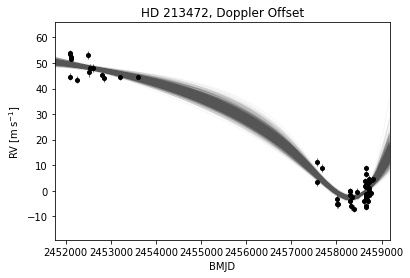

In [10]:
fig = tj.plot_rv_curves(samples, rv_unit=u.m/u.s, data=[rvdata_j, rvdata_k])
ax = fig.axes[0]
ax.set_title('HD 213472, Doppler Offset')
fig.savefig('213472_orbit_dopploff.png')

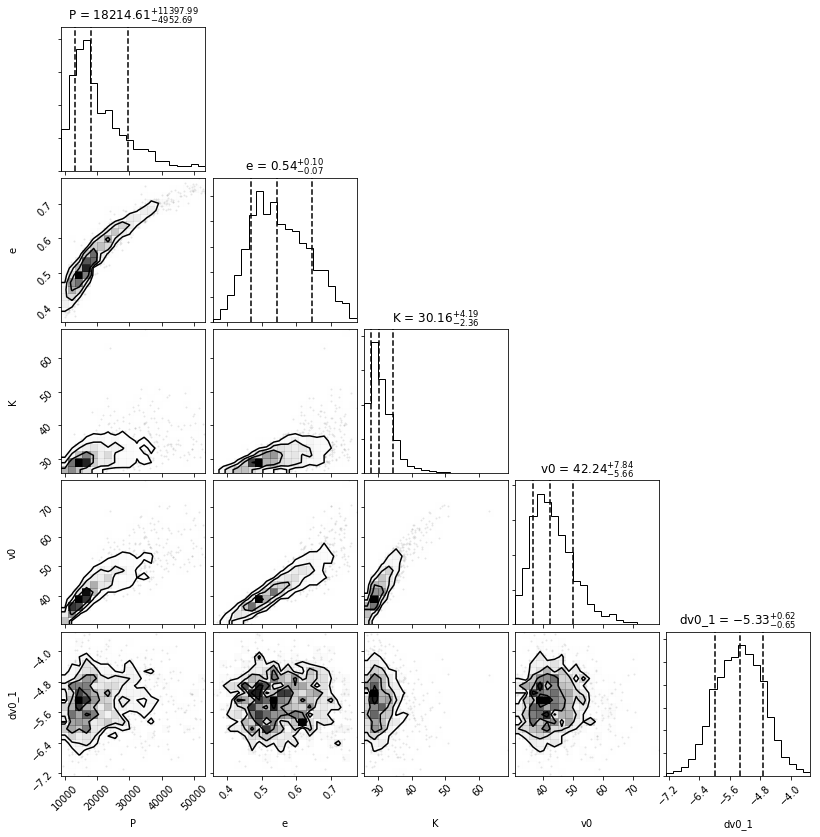

In [13]:
P = np.array(samples['P']/samples['P'].unit)
M0 = np.array(samples['M0']/samples['M0'].unit)
e = np.array(samples['e']/samples['e'].unit)
omega = np.array(samples['omega']/samples['omega'].unit)
jitter = np.array(samples['s']/samples['s'].unit)
K = np.array(samples['K']/samples['K'].unit)
v0 = np.array(samples['v0']/samples['v0'].unit)
dv0_1 = np.array(samples['dv0_1']/samples['dv0_1'].unit)

jchains = pd.DataFrame.from_dict({'P':P,'e':e, 
                                  'K':np.abs(K), 'v0':v0, 'dv0_1':dv0_1})
jchains.to_csv('213472_chains_826.csv')

fig = corner.corner(jchains, labels=['P', 'e', 'K', 'v0', 'dv0_1'],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})
fig.savefig('213472_corner_1120.pdf')

In [25]:
with params.model:
    mcmc_init = joker.setup_mcmc([rvdata_j, rvdata_k], samples)
    
    trace = pm.sample(tune=1000, draws=1000,
                     start=mcmc_init,
                     step=xo.get_dense_nuts_step(target_accept=0.95))

mcmc_samples = joker.trace_to_samples(trace, [rvdata_j, rvdata_k])
mcmc_samples.wrap_K()

df = mcmc_samples.tbl.to_pandas().query('P < 10**10')
#truths = []
colnames = []
for name in df.columns:
    colnames.append(name)
#    #truths.append(truth[name].value)
_ = corner.corner(df[colnames])#, truths=truths)

<JokerSamples [P, e, omega, M0, s, K, v0, dv0_1] (4000 samples)>

## Do the same, for HD 111031.

In [2]:
data11 = pd.read_csv('../../rvdata/vst111031.csv')
data11['jd'] = data11['bjd']
data11 = data11.sort_values('jd')

In [3]:
time = np.asarray(data11.jd)
mnvel = np.asarray(data11.mnvel)
errvel = np.asarray(data11.errvel)

#Use correct units for RVs. Time is in days for TheJoker.
time   *= u.day
mnvel  *= u.m/u.s
errvel *= u.m/u.s

In [4]:
rvdata = RVData(t=time, rv=mnvel, stddev=errvel)
baseline = np.amax(time) - np.amin(time)
baseline

<Quantity 8105.7169004 d>

In [5]:
params = JokerParams(P_min=baseline, P_max=4*baseline)
joker = TheJoker(params)
samples = joker.rejection_sample(rvdata, n_prior_samples=2*10**8)

INFO: 4085 good samples after rejection sampling [thejoker.sampler.sampler]


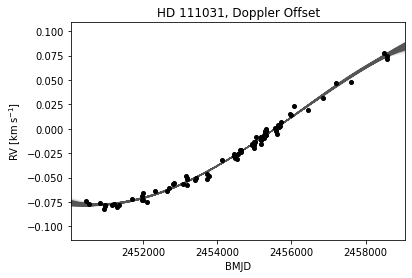

In [6]:
fig = plot_rv_curves(samples, data=rvdata)
ax = fig.axes[0]
ax.set_title('HD 111031, Doppler Offset')
fig.savefig('111031_orbit_dopploff.pdf')

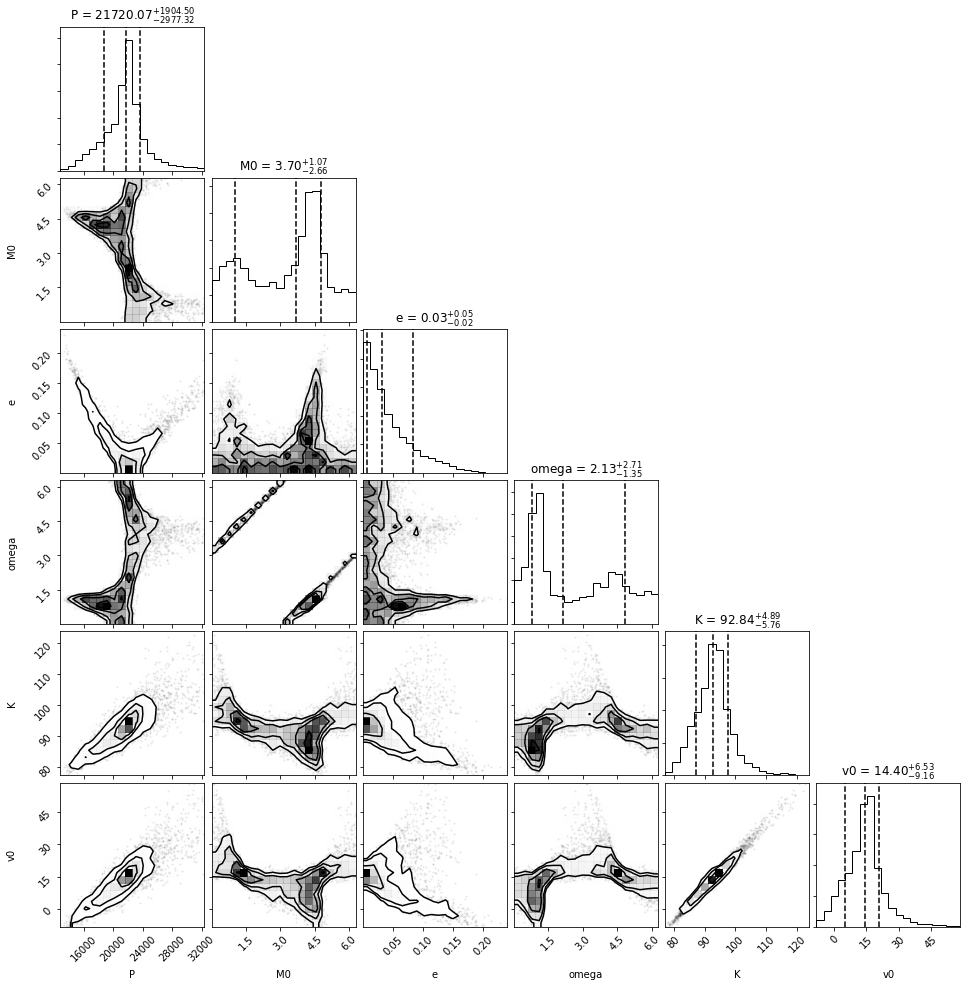

In [7]:
P = np.array(samples['P']/samples['P'].unit)
M0 = np.array(samples['M0']/samples['M0'].unit)
e = np.array(samples['e']/samples['e'].unit)
omega = np.array(samples['omega']/samples['omega'].unit)
jitter = np.array(samples['jitter']/samples['jitter'].unit)
K = np.array(samples['K']/samples['K'].unit)
v0 = np.array(samples['v0']/samples['v0'].unit)

jchains = pd.DataFrame.from_dict({'P':P, 'M0':M0, 'e':e, 'omega':omega, 'K':K, 'v0':v0})
jchains.to_csv('111031_chains_dopploff.csv')

fig = corner.corner(jchains, labels=['P', 'M0', 'e', 'omega', 'K', 'v0'],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})
fig.savefig('111031_corner_dopploff.pdf')

## Do the same, for HD 26161.

In [8]:
data = pd.read_csv('../../rvdata/vst26161.csv')

In [9]:
time = np.asarray(data.jd)
mnvel = np.asarray(data.mnvel)
errvel = np.asarray(data.errvel)
jitter = np.median(errvel)

#Use correct units for RVs. Time is in days for TheJoker.
time   *= u.day
mnvel  *= u.m/u.s
errvel *= u.m/u.s
jitter *= u.m/u.s

In [10]:
# Set up Joker data object.
rvdata = RVData(t=time, rv=mnvel, stddev=errvel)
baseline = np.amax(time) - np.amin(time)
print(baseline)

7652.1667679999955 d


In [ ]:
# Set up Joker sampler.
params = JokerParams(P_min=baseline, P_max=8*baseline)
joker = TheJoker(params)
samples = joker.rejection_sample(rvdata, n_prior_samples=2*10**8)
#with schwimmbad.MultiPool() as pool:
#    joker = TheJoker(params, pool=pool)
#    samples = joker.rejection_sample(rvdata, n_prior_samples=5*10**8)

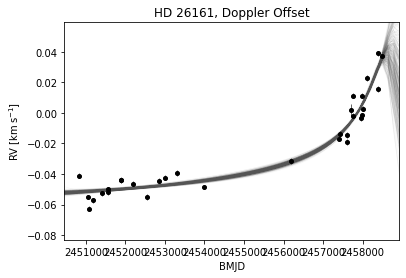

In [23]:
fig = plot_rv_curves(samples, data=rvdata)
ax = fig.axes[0]
ax.set_title('HD 26161, Doppler Offset')
fig.savefig('26161_orbit_827.pdf')

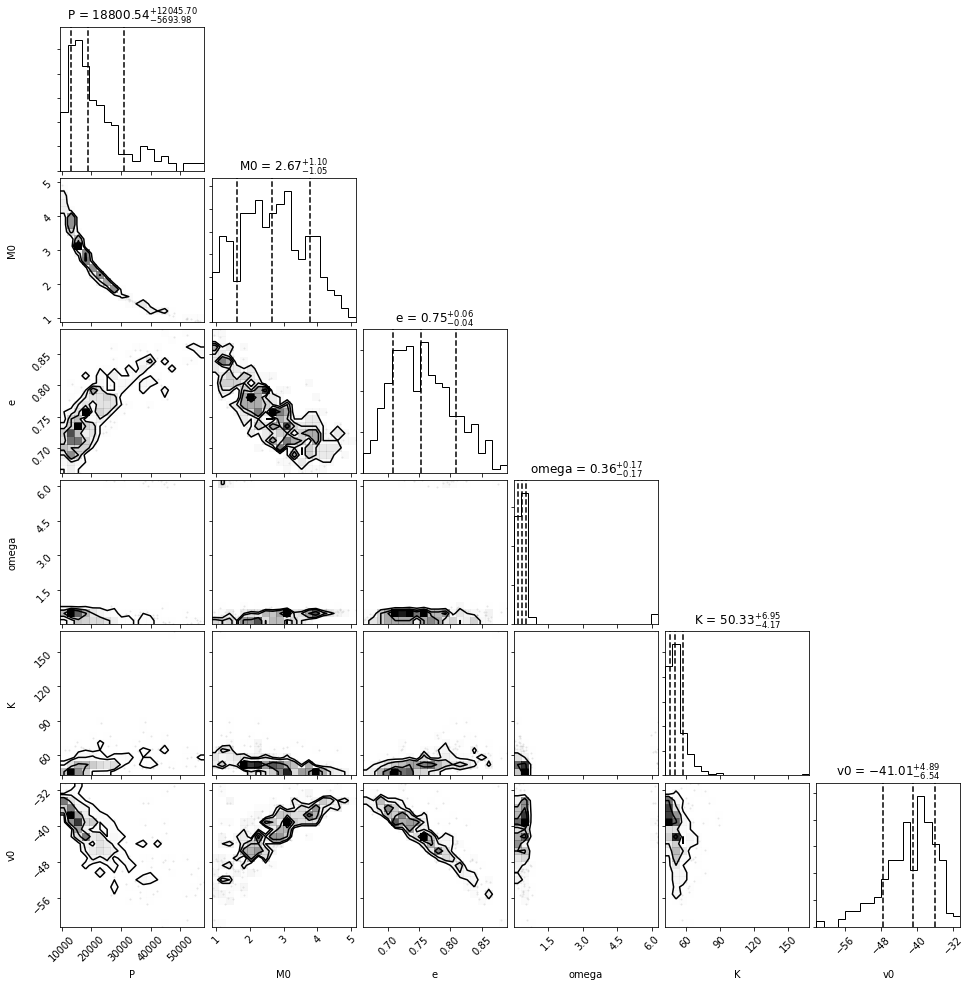

In [31]:
P = np.array(samples['P']/samples['P'].unit)
M0 = np.array(samples['M0']/samples['M0'].unit)
e = np.array(samples['e']/samples['e'].unit)
omega = np.array(samples['omega']/samples['omega'].unit)
jitter = np.array(samples['jitter']/samples['jitter'].unit)
K = np.array(samples['K']/samples['K'].unit)
v0 = np.array(samples['v0']/samples['v0'].unit)

jchains = pd.DataFrame.from_dict({'P':P, 'M0':M0, 'e':e, 'omega':omega, 'K':K, 'v0':v0})
jchains.to_csv('26161_chains_827.csv')

fig = corner.corner(jchains, labels=['P', 'M0', 'e', 'omega', 'K', 'v0'],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})
fig.savefig('26161_corner_827.pdf')

## Combine 26161 chains, remake the corner plot.

In [32]:
part1_26161 = pd.read_csv('26161_chains_8xbase_1.csv')
part2_26161 = pd.read_csv('26161_chains_8xbase_2.csv')
part3_26161 = pd.read_csv('26161_chains_8xbase_3.csv')
part4_26161 = pd.read_csv('26161_chains_8xbase_4.csv')
part5_26161 = pd.read_csv('26161_chains_8xbase_5.csv')
part6_26161 = pd.read_csv('26161_chains_8xbase_6.csv')
part7_26161 = pd.read_csv('26161_chains_8xbase_7.csv')
full_26161 = part1_26161.append(part2_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part3_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part4_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part5_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part6_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part7_26161, ignore_index=True).reset_index(drop=True)

full_26161 = full_26161[['P', 'M0', 'e', 'omega', 'K', 'v0']]
full_26161.to_csv('26161_chains_8xbase_full.csv')

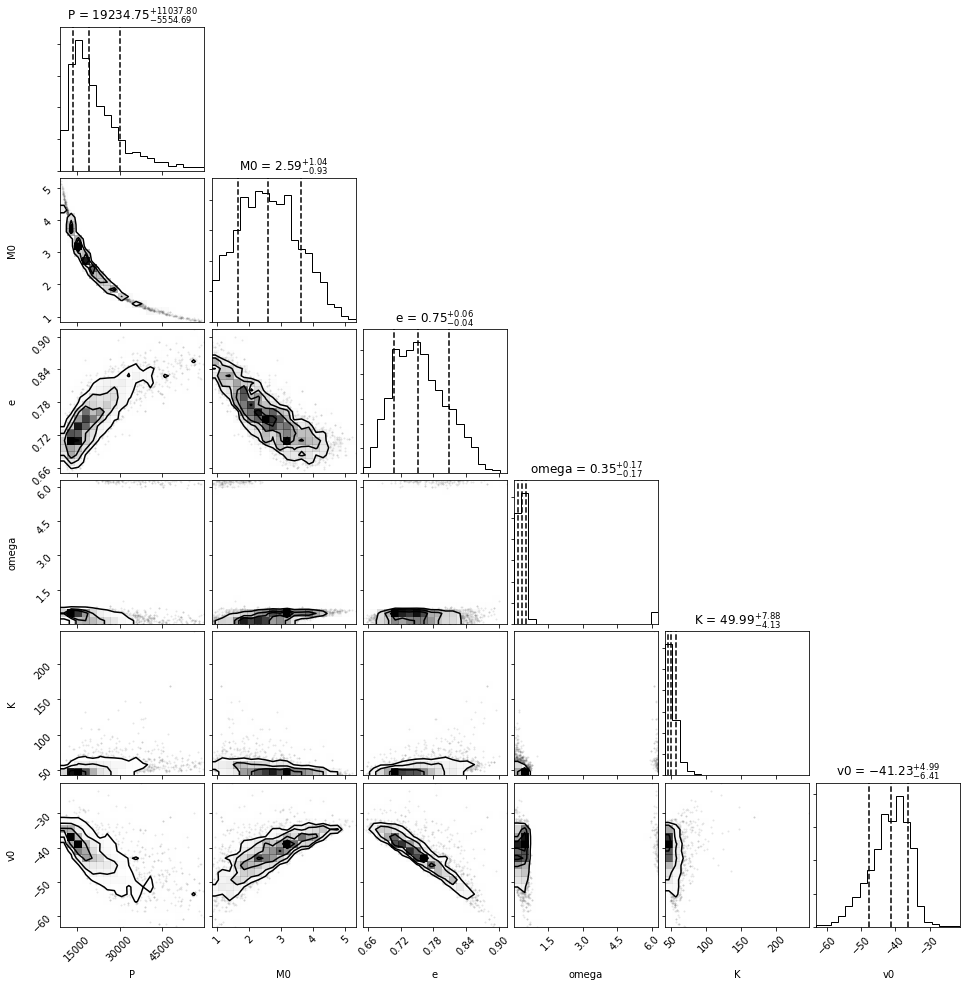

In [33]:
fig = corner.corner(full_26161, labels=['P', 'M0', 'e', 'omega', 'K', 'v0'],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})
fig.savefig('26161_corner_8xbase_full.pdf')

## Same for 66428. Subtract the orbit of the inner gas giant.

In [19]:
data = pd.read_csv('../../rvdata/vst66428.csv')
post = radvel.posterior.load('66428/post_final.pkl')

time = np.asarray(data.jd)
mnvel = np.asarray(data.mnvel)
errvel = np.asarray(data.errvel)

#Subtract orbit of inner gas giant.
orbel = [post.params['per1'].value, post.params['tp1'].value,
         post.params['e1'].value, post.params['w1'].value,
         post.params['k1'].value]
mod = radvel.kepler.rv_drive(time, orbel)
mnvel -= mod

#Correct for gamma offsets.

#Use correct units for RVs. Time is in days for TheJoker.
time   *= u.day
mnvel  *= u.m/u.s
errvel *= u.m/u.s

In [22]:
print(post.params['gamma_k'].value, post.params['gamma_j'].value)

4.1749493292628035 13.460665227680648


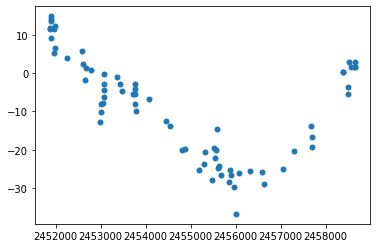

In [20]:
fig, ax = plt.subplots()
ax.scatter(time, mnvel)

In [23]:
# Set up Joker data object.
rvdata = RVData(t=time, rv=mnvel, stddev=errvel)
baseline = np.amax(time) - np.amin(time)

params = JokerParams(P_min=baseline, P_max=8*baseline)
joker = TheJoker(params)
samples = joker.rejection_sample(rvdata, n_prior_samples=2*10**8)

INFO: 391 good samples after rejection sampling [thejoker.sampler.sampler]


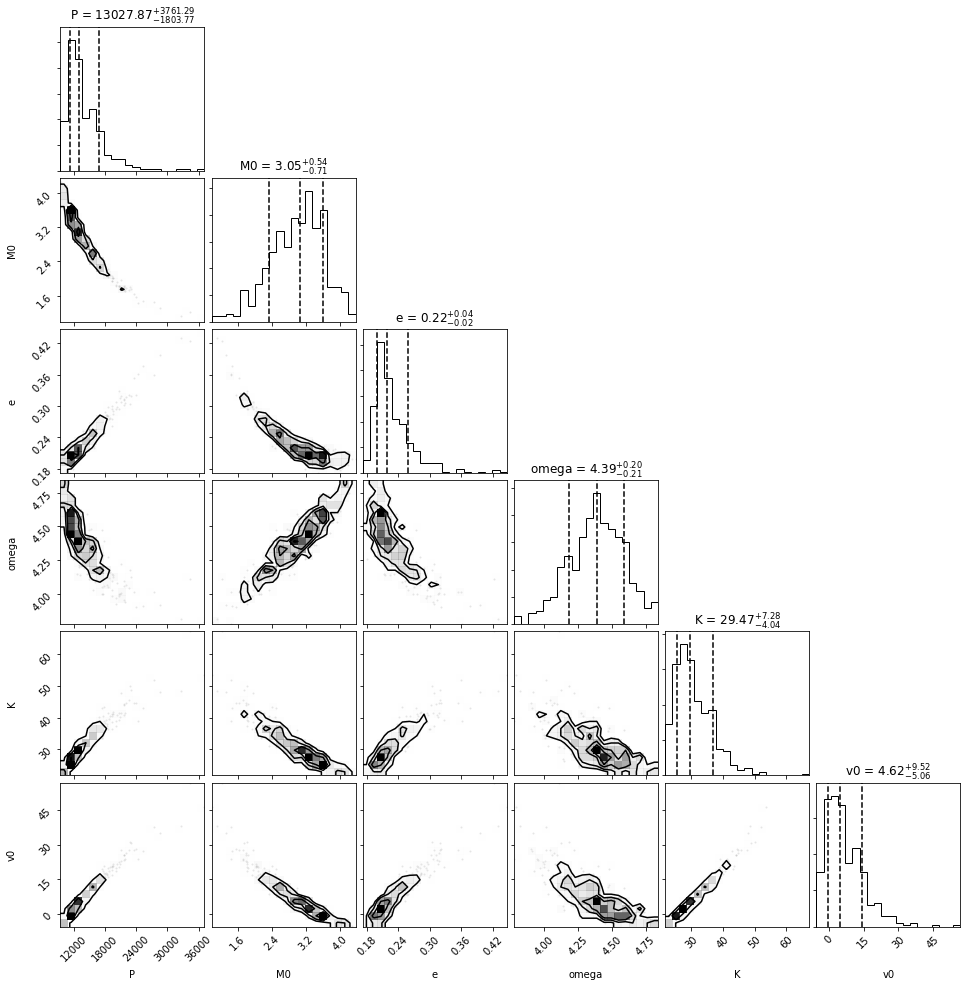

In [24]:
P = np.array(samples['P']/samples['P'].unit)
M0 = np.array(samples['M0']/samples['M0'].unit)
e = np.array(samples['e']/samples['e'].unit)
omega = np.array(samples['omega']/samples['omega'].unit)
jitter = np.array(samples['jitter']/samples['jitter'].unit)
K = np.array(samples['K']/samples['K'].unit)
v0 = np.array(samples['v0']/samples['v0'].unit)

jchains = pd.DataFrame.from_dict({'P':P, 'M0':M0, 'e':e, 'omega':omega, 'K':K, 'v0':v0})
jchains.to_csv('111031_chains_dopploff.csv')

fig = corner.corner(jchains, labels=['P', 'M0', 'e', 'omega', 'K', 'v0'],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})
fig.savefig('66428_corner_bad_offset.pdf')

## Same for HD 136925.

In [2]:
data = pd.read_csv('../rvdata/vst136925.csv')

time = np.asarray(data.jd) - np.median(data.jd)
mnvel = np.asarray(data.mnvel)
errvel = np.asarray(data.errvel)
# Make initial guess at jitter from HIRES errors.
jitter = np.median(errvel)

#Use correct units for RVs. Time is in days for TheJoker.
time   *= u.day
mnvel  *= u.m/u.s
errvel *= u.m/u.s
jitter *= u.m/u.s

In [ ]:
rvdata = RVData(t=time, rv=mnvel, stddev=errvel)
baseline = np.amax(time) - np.amin(time)

# Bangogram best-fit period is 3908 days.
params = JokerParams(P_min=3930*u.day, P_max=3960*u.day)
joker = TheJoker(params)
samples = joker.rejection_sample(rvdata, n_prior_samples=2*10**8)

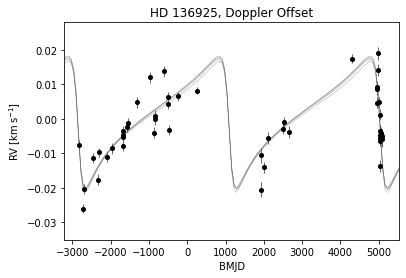

In [4]:
fig = plot_rv_curves(samples, data=rvdata)
ax = fig.axes[0]
ax.set_title('HD 136925, Doppler Offset')
fig.savefig('136925_orbit_1111.pdf')

In [6]:
P = np.array(samples['P']/samples['P'].unit)
M0 = np.array(samples['M0']/samples['M0'].unit)
e = np.array(samples['e']/samples['e'].unit)
omega = np.array(samples['omega']/samples['omega'].unit)
jitter = np.array(samples['jitter']/samples['jitter'].unit)
K = np.array(samples['K']/samples['K'].unit)
v0 = np.array(samples['v0']/samples['v0'].unit)

jchains = pd.DataFrame.from_dict({'P':P, 'M0':M0, 'e':e, 'omega':omega, 'K':K, 'v0':v0})
jchains.to_csv('136925_chains_1111.csv')

In [7]:
P

array([3944.38780816, 3944.54996617, 3941.77370935, 3948.00003025,
       3944.24905111])

In [5]:
fig = corner.corner(jchains, labels=['P', 'M0', 'e', 'omega', 'K', 'v0'],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})
fig.savefig('136925_corner_1111.pdf')

AssertionError: I don't believe that you want more dimensions than samples!

## After the fact, load the posteriors, read in masses, and compute physical parameters. For each parameter, compute the posterior maximum, median, and quantiles.

In [13]:
chain_26161  = pd.read_csv('26161_chains_dopploff_full.csv')
chain_111031 = pd.read_csv('111031_chains_dopploff.csv')
chain_213472 = pd.read_csv('213472_chains_dopploff_20.csv')

mstar_26161   = 1.1126
umstar_26161  = 0.0755
mstar_111031  = 1.1450
umstar_111031 = 0.0828
mstar_213472  = 1.0450
umstar_213472 = 0.0713

starchain_26161 = np.random.normal(mstar_26161, umstar_26161, len(chain_26161)).clip(0.001, 100)
starchain_111031 = np.random.normal(mstar_111031, umstar_111031, len(chain_111031)).clip(0.001, 100)
starchain_213472 = np.random.normal(mstar_213472, umstar_213472, len(chain_213472)).clip(0.001, 100)

print(chain_26161.columns)

Index(['Unnamed: 0', 'P', 'M0', 'e', 'omega', 'K', 'v0'], dtype='object')


### One star at a time. 26161, 111031, 213472.

In [22]:
ks_26161 = np.asarray(chain_26161['K'])
es_26161 = np.asarray(chain_26161['e'])
pers_26161 = np.asarray(chain_26161['P'])

masses_26161 = radvel.utils.Msini(ks_26161, pers_26161, starchain_26161, 
                                  es_26161, Msini_units='jupiter')
axes_26161 = radvel.utils.semi_major_axis(pers_26161, starchain_26161)

k_med_26161 = np.median(ks_26161)
e_med_26161 = np.median(es_26161)
per_med_26161 = np.median(pers_26161)
mass_med_26161 = np.median(masses_26161)
axis_med_26161 = np.median(axes_26161)

k_min_26161 = np.percentile(ks_26161, 15.9)
e_min_26161 = np.percentile(es_26161, 15.9)
per_min_26161 = np.percentile(pers_26161, 15.9)
mass_min_26161 = np.percentile(masses_26161, 15.9)
axis_min_26161 = np.percentile(axes_26161, 15.9)

k_plus_26161 = np.percentile(ks_26161, 84.1)
e_plus_26161 = np.percentile(es_26161, 84.1)
per_plus_26161 = np.percentile(pers_26161, 84.1)
mass_plus_26161 = np.percentile(masses_26161, 84.1)
axis_plus_26161 = np.percentile(axes_26161, 84.1)

print('26161')
print('k:', k_min_26161, k_med_26161, k_plus_26161)
print('e:', e_min_26161, e_med_26161, e_plus_26161)
print('per:', per_min_26161, per_med_26161, per_plus_26161)
print('mass:', mass_min_26161, mass_med_26161, mass_plus_26161)
print('axis:', axis_min_26161, axis_med_26161, axis_plus_26161)

26161
k: 45.61861967496441 50.03395671093202 57.55852853267207
e: 0.7089778008632901 0.7533977021673797 0.8066300942189226
per: 14105.231467749254 20448.126913243657 28702.106899041875
mass: 4.041126050299845 4.672363877383036 5.718860683213387
axis: 11.754491743987852 14.937685063617229 19.090197157589394


In [21]:
ks_111031 = np.asarray(chain_111031['K'])
es_111031 = np.asarray(chain_111031['e'])
pers_111031 = np.asarray(chain_111031['P'])

masses_111031 = radvel.utils.Msini(ks_111031, pers_111031, starchain_111031, 
                                  es_111031, Msini_units='jupiter')
axes_111031 = radvel.utils.semi_major_axis(pers_111031, starchain_111031)

k_med_111031 = np.median(ks_111031)
e_med_111031 = np.median(es_111031)
per_med_111031 = np.median(pers_111031)
mass_med_111031 = np.median(masses_111031)
axis_med_111031 = np.median(axes_111031)

k_min_111031 = np.percentile(ks_111031, 15.9)
e_min_111031 = np.percentile(es_111031, 15.9)
per_min_111031 = np.percentile(pers_111031, 15.9)
mass_min_111031 = np.percentile(masses_111031, 15.9)
axis_min_111031 = np.percentile(axes_111031, 15.9)

k_plus_111031 = np.percentile(ks_111031, 84.1)
e_plus_111031 = np.percentile(es_111031, 84.1)
per_plus_111031 = np.percentile(pers_111031, 84.1)
mass_plus_111031 = np.percentile(masses_111031, 84.1)
axis_plus_111031 = np.percentile(axes_111031, 84.1)

print('111031')
print('k:', k_min_111031, k_med_111031, k_plus_111031)
print('e:', e_min_111031, e_med_111031, e_plus_111031)
print('per:', per_min_111031, per_med_111031, per_plus_111031)
print('mass:', mass_min_111031, mass_med_111031, mass_plus_111031)
print('axis:', axis_min_111031, axis_med_111031, axis_plus_111031)

111031
k: 87.15711839138939 92.7558292966547 97.66986508434483
e: 0.008139665565739265 0.03169619354471433 0.08988991996880974
per: 18812.122103771897 21797.800719551167 23660.87019758344
mass: 12.351951645792159 13.879267128764756 15.363075888811984
axis: 14.396244894553025 15.921426030060037 17.01094939909186


In [16]:
ks_213472 = np.asarray(chain_213472['K'])
es_213472 = np.asarray(chain_213472['e'])
pers_213472 = np.asarray(chain_213472['P'])

masses_213472 = radvel.utils.Msini(ks_213472, pers_213472, starchain_213472, 
                                  es_213472, Msini_units='jupiter')
axes_213472 = radvel.utils.semi_major_axis(pers_213472, starchain_213472)

k_213472 = stats.mode(ks_213472)
e_213472 = stats.mode(es_213472)
per_213472 = stats.mode(pers_213472)
mass_213472 = stats.mode(masses_213472)
axis_213472 = stats.mode(axes_213472)

k_med_213472 = np.median(ks_213472)
e_med_213472 = np.median(es_213472)
per_med_213472 = np.median(pers_213472)
mass_med_213472 = np.median(masses_213472)
axis_med_213472 = np.median(axes_213472)

k_min_213472 = np.percentile(ks_213472, 15.9)
e_min_213472 = np.percentile(es_213472, 15.9)
per_min_213472 = np.percentile(pers_213472, 15.9)
mass_min_213472 = np.percentile(masses_213472, 15.9)
axis_min_213472 = np.percentile(axes_213472, 15.9)

k_plus_213472 = np.percentile(ks_213472, 84.1)
e_plus_213472 = np.percentile(es_213472, 84.1)
per_plus_213472 = np.percentile(pers_213472, 84.1)
mass_plus_213472 = np.percentile(masses_213472, 84.1)
axis_plus_213472 = np.percentile(axes_213472, 84.1)

In [23]:
print('213472')
print('k:', k_min_213472, k_med_213472, k_plus_213472)
print('e:', e_min_213472, e_med_213472, e_plus_213472)
print('per:', per_min_213472, per_med_213472, per_plus_213472)
print('mass:', mass_min_213472, mass_med_213472, mass_plus_213472)
print('axis:', axis_min_213472, axis_med_213472, axis_plus_213472)

213472
k: 25.115344922400634 26.418958082649766 29.1290345658689
e: 0.4844481415601038 0.5659319908321765 0.6802928683212921
per: 13221.157802427844 18204.94372636474 30194.906885071436
mass: 2.643572837304431 2.931018565051104 3.367780574860644
axis: 11.112566991458609 13.753773517354123 19.401907153940417
